In [57]:
from settings.common import get_pp_pipeline, load_flat_dataset, save_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
from preprocessing_pipeline.NextGen import NextGen
import csv
from settings.common import load_flat_dataset
from settings.ngrams import insert_ngrams_flat_from_lists
import pandas as pd 

In [58]:
dataset_name = 'fact_checker_data'

data_path = 'data_gtm/{}.csv'

pp = get_pp_pipeline(remove_stopwords=True, stem=False, clean_twitter=False)

ds_path = data_path.format(dataset_name+"_raw")

In [59]:
raw_data = pd.DataFrame(pd.read_csv(ds_path).claim)

In [60]:
raw_data.to_csv(data_path.format(dataset_name), header=False, index=False)

In [61]:
ds_path = data_path.format(dataset_name)

In [62]:
dataset = load_flat_dataset(ds_path, delimiter=' ')

In [63]:
ng = NextGen()
clean_ds = ng._preprocess_dataset(dataset=dataset, pp=pp)
save_flat_dataset(data_path.format(dataset_name), clean_ds, delimiter=' ')

In [64]:
dataset = []
from src.gdtm.helpers.common import load_flat_dataset
from src.gdtm.models import GTM, NLDA

tnd_path = '../topic-noise-models-source/mallet-tnd/bin/mallet'
lda_path = '../topic-noise-models-source/mallet-lda/bin/mallet'
gtm_path = '../topic-noise-models-source/mallet-gtm/bin/mallet'
dataset = load_flat_dataset("data_gtm/{}.csv".format(dataset_name))

In [65]:
all_bigram = []
for i in dataset:
    tmp = []
    for index in range(0,len(i)-1):
        tmp.append('$'.join(i[index:index+2]))
    all_bigram.append(tmp)
dataset.extend(all_bigram)

In [66]:
len(dataset)

888

### Find the best K

In [12]:
coherence_list = []
for n in range(2, 21):
    model = NLDA(dataset=dataset, mallet_tnd_path=tnd_path, mallet_lda_path=lda_path, 
             tnd_k=n, lda_k=n, tnd_beta1 = int(5*n/6), phi=int(n/3), top_words=20)
    coherence_list.append(model.get_coherent())

In [13]:
import matplotlib.pyplot as plt

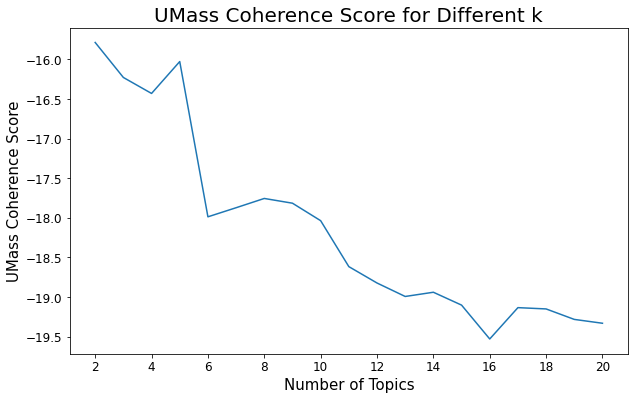

In [14]:
plt.figure(figsize=(10,6))
plt.plot(range(2, 21),coherence_list)
plt.xlabel("Number of Topics", fontsize=15)
plt.ylabel("UMass Coherence Score", fontsize=15)
plt.xticks(range(2, 21, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.title("UMass Coherence Score for Different k", fontsize=20)
plt.savefig("Coherence_Score.png", dpi=300)

In [67]:
model = NLDA(dataset=dataset, mallet_tnd_path=tnd_path, mallet_lda_path=lda_path, 
             tnd_k=20, lda_k=20, tnd_beta1=16, phi=12, top_words=20)

In [68]:
topics = model.get_topics()
noise = model.get_noise_distribution()
topic_formula = model.show_topics()
coherence = model.get_coherent()
print("Noise:",noise)
print("\nTopics:", topic_formula)
print("\nUMass Coherence Score:", coherence)

Noise: [('president', 326), ('biden', 112), ('joe', 90), ('trump', 71), ('joe$biden', 68), ('2020', 57), ('president$joe', 55), ('donald', 45), ('donald$trump', 43), ('2021', 43), ('ballots', 38), ('election', 35), ('president$donald', 35), ('votes', 33), ('presidential', 33), ('vote', 33), ('former$president', 30), ('bidens', 29), ('voter', 27), ('people', 26), ('presidential$election', 25), ('2020$election', 25), ('voting', 23), ('house', 22), ('shows', 22), ('white', 21), ('million', 20), ('county', 20), ('2020$presidential', 20), ('video', 19), ('state', 19), ('ukraine', 18), ('fraud', 18), ('joe$bidens', 18), ('hunter', 17), ('arizona', 17), ('jobs', 16), ('states', 16), ('americans', 15), ('voted', 15), ('voters', 15), ('democrats', 14), ('drop', 13), ('maricopa', 13), ('show', 13), ('office', 13), ('white$house', 13), ('hunter$biden', 12), ('illegal', 12), ('american', 11), ('jan', 11), ('senate', 11), ('wisconsin', 11), ('mailin', 11), ('ballot', 10), ('federal', 10), ('united'

In [69]:
noise_word = [term for term, wt in noise[:50]]
noise_wt = [wt for term, wt in noise[:50]]
noise_data = pd.DataFrame([noise_word, noise_wt]).T.rename(columns={0:"Noise_Word", 1:"Noise_Weight"}).sort_values(by="Noise_Weight", ascending=True)

In [72]:
clean_topic = []
for topic in topics:
    temp=[]
    for t in topic:
        if t not in noise_word:
            temp.append(t)
    clean_topic.append(temp)

In [74]:
with open('data_gtm/'+dataset_name+"_topics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(clean_topic)

In [21]:
print(noise_word)

['election', 'biden', '2020', 'ballots', 'hunter$biden', 'president', 'joe', 'hunter', '2021', 'bidens', 'joe$biden', 'county', '2020$election', 'ukraine', 'laptop', 'votes', 'presidential$election', 'mailin', 'trump', '2020$presidential', 'voting', 'georgia', 'arrested', 'president$joe', 'voter', 'oil', 'arizona', 'illegal', 'fraud', 'military', 'elected', 'son', 'show', 'rigged', 'april$2021', 'pennsylvania', 'people', 'million', 'april', 'mailin$ballots', 'state', 'democrats', 'elections', 'states', 'gas', 'mail', 'biden$arrested', 'biden$said', 'broadcast$april', 'broadcast']


/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


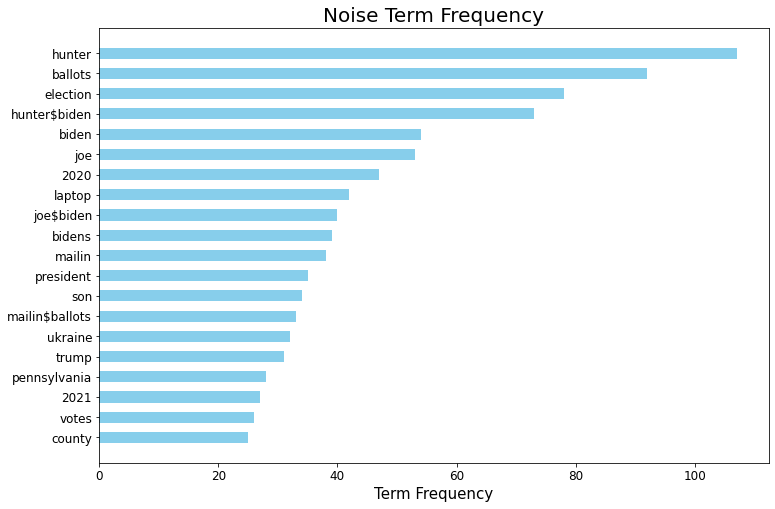

In [262]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(noise_data.Noise_Word, noise_data.Noise_Weight, height=0.55, color="skyblue")
plt.xlabel("Term Frequency", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Noise Term Frequency", fontsize=20)
plt.savefig("Noise.png", dpi=300)

In [263]:
doc_topic = model.lda_model[model.corpus]

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [264]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in doc_topic]

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [266]:
topics = [[(term, round(wt, 3)) for term, wt in topic_formula[n][1]] for n in range(0, 5)]

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [268]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], 
                         columns = ['Term'+str(i) for i in range(1, 21)], 
                         index=['Topic '+str(t) for t in range(1, 5+1)]).T
topics_df

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Term1,ballots,hunter$biden,hunter,biden,mailin$ballots
Term2,election,joe$biden,biden,joe,trump
Term3,2020,hunter$bidens,laptop,president,pennsylvania
Term4,mailin,2020$presidential,bidens,ukraine,votes
Term5,georgia,president$joe,white,son,presidential$election
Term6,presidential,bidens$laptop,hunters$laptop,2021,oil
Term7,county,biden$arrested,hunters,military,state
Term8,mail,biden$said,arrested,million,arizona
Term9,counted,april$2021,found,april,2020$election
Term10,voter,vote,photograph,burisma,says$hunter


In [269]:
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], 
                         columns = ['Terms per Topic'], 
                         index=['Topic'+str(t) for t in range(1, 5+1)] )
topics_df

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-269-09aa486b703a>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"ballots, election, 2020, mailin, georgia, presidential, county, mail, counted, voter, workers, rigged, absentee, fraud, fraudulent, thrown, part, people, recall, back"
Topic2,"hunter$biden, joe$biden, hunter$bidens, 2020$presidential, president$joe, bidens$laptop, biden$arrested, biden$said, april$2021, vote, california, biden$died, broadcast$april, biden$son, 2021$hunter, young$girl, obamas$credit, interview$broadcast, malia$obamas, son$hunter"
Topic3,"hunter, biden, laptop, bidens, white, hunters$laptop, hunters, arrested, found, photograph, young, show, credit, card, obamas, overdose, cocaine, malia, security, chinese"
Topic4,"biden, joe, president, ukraine, son, 2021, military, million, april, burisma, president$trump, girl, broadcast, lost, crack, died, company, aid, china, interview"
Topic5,"mailin$ballots, trump, pennsylvania, votes, presidential$election, oil, state, arizona, 2020$election, says$hunter, illegal, ballot, officials, voting, ballots$counted, invested, mail$ballots, senate, family, program"


/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


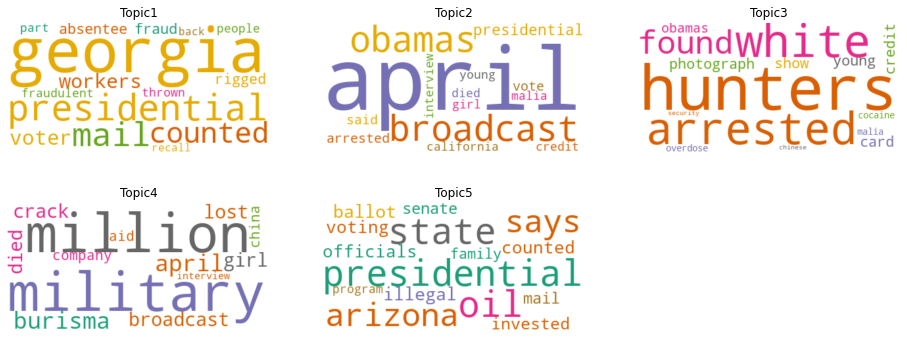

In [275]:
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42, stopwords=noise_word)

# set the figure size
plt.rcParams['figure.figsize'] = [16, 16]

# Create subplots for each topic
for i in range(5):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])
plt.savefig("Wordcloud.png", dpi=300)
plt.show()

In [271]:
from gensim.models.ldamodel import LdaModel
def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, 
        num_topics=5,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1]:
ldagensim = convertldaMalletToldaGen(model.lda_model)

NameError: name 'convertldaMalletToldaGen' is not defined

In [2]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(ldagensim, model.corpus, model.lda_model.id2word, sort_topics=False)
pyLDAvis.display(vis_data)

NameError: name 'ldagensim' is not defined

In [31]:
pyLDAvis.save_html(vis_data, "Topic_Vis.html")

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [310]:
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
df = pd.read_csv("data/fact_checker_data_raw.csv")

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [311]:
df.shape

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(307, 9)

In [312]:
corpus_topic_df['keyword'] = df.keyword
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics[:307]]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics[:307]]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics[:307]]
corpus_topic_df.head()

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,keyword,Dominant Topic,Contribution %,Topic Terms
0,rigged-election,3,22.64,"hunter, biden, laptop, bidens, white, hunters$laptop, hunters, arrested, found, photograph, young, show, credit, card, obamas, overdose, cocaine, malia, security, chinese"
1,rigged-election,3,26.55,"hunter, biden, laptop, bidens, white, hunters$laptop, hunters, arrested, found, photograph, young, show, credit, card, obamas, overdose, cocaine, malia, security, chinese"
2,rigged-election,2,22.22,"hunter$biden, joe$biden, hunter$bidens, 2020$presidential, president$joe, bidens$laptop, biden$arrested, biden$said, april$2021, vote, california, biden$died, broadcast$april, biden$son, 2021$hunter, young$girl, obamas$credit, interview$broadcast, malia$obamas, son$hunter"
3,rigged-election,3,22.63,"hunter, biden, laptop, bidens, white, hunters$laptop, hunters, arrested, found, photograph, young, show, credit, card, obamas, overdose, cocaine, malia, security, chinese"
4,rigged-election,3,24.07,"hunter, biden, laptop, bidens, white, hunters$laptop, hunters, arrested, found, photograph, young, show, credit, card, obamas, overdose, cocaine, malia, security, chinese"


In [313]:
import numpy as np
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus_topics[:307]), 2))

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].astype("str")

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc']+"%"

dominant_topic_df['Topic Terms'] = topics_df.reset_index(drop=True)['Terms per Topic'].str.replace("$","-")

dominant_topic_df

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-313-fbe62d668a37>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  dominant_topic_df['Topic Terms'] = topics_df.reset_index(drop=True)['Terms per Topic'].str.replace("$","-")


,Dominant Topic,Doc_Count,Total_Docs_Perc,Topic Terms
0,1,123,40.07%,"ballots, election, 2020, mailin, georgia, presidential, county, mail, counted, voter, workers, rigged, absentee, fraud, fraudulent, thrown, part, people, recall, back"
1,2,5,1.63%,"hunter-biden, joe-biden, hunter-bidens, 2020-presidential, president-joe, bidens-laptop, biden-arrested, biden-said, april-2021, vote, california, biden-died, broadcast-april, biden-son, 2021-hunter, young-girl, obamas-credit, interview-broadcast, malia-obamas, son-hunter"
2,3,78,25.41%,"hunter, biden, laptop, bidens, white, hunters-laptop, hunters, arrested, found, photograph, young, show, credit, card, obamas, overdose, cocaine, malia, security, chinese"
3,4,56,18.24%,"biden, joe, president, ukraine, son, 2021, military, million, april, burisma, president-trump, girl, broadcast, lost, crack, died, company, aid, china, interview"
4,5,45,14.66%,"mailin-ballots, trump, pennsylvania, votes, presidential-election, oil, state, arizona, 2020-election, says-hunter, illegal, ballot, officials, voting, ballots-counted, invested, mail-ballots, senate, family, program"


In [314]:
corpus_topic_df['date'] = pd.to_datetime(df.date).dt.to_period('M')

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [315]:
trend_topic = corpus_topic_df.groupby(["date", "Dominant Topic"]).count()["keyword"].reset_index()

#trend_topic_total = trend_topic.groupby("date").sum().reset_index()[["date", "keyword"]].rename(columns = {"keyword":"total"})
trend_topic_total = trend_topic.groupby("Dominant Topic").sum().reset_index()[["Dominant Topic", "keyword"]].rename(columns = {"keyword":"total"})

trend_topic = trend_topic.merge(trend_topic_total, on=["Dominant Topic"], how = "left")

trend_topic["Percentage"] = trend_topic.keyword / trend_topic.total

trend_topic.date = trend_topic.date.astype("str")
trend_topic = trend_topic[trend_topic.date!="2020-09"]

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


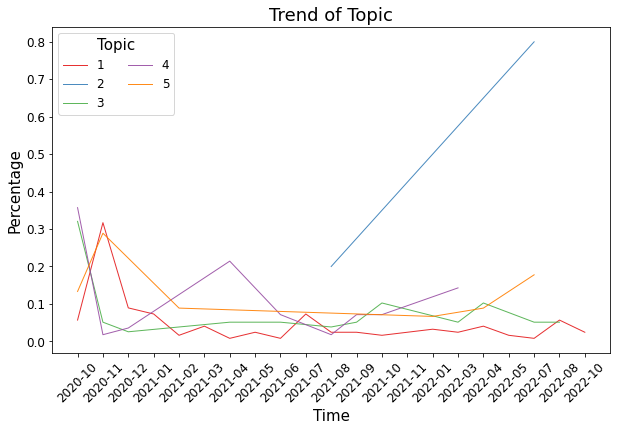

In [316]:
# Create a color palette
palette = plt.get_cmap('Set1')

plt.figure(figsize=(10,6))
# Plot multiple lines
for topic in range(1,6):
    plt.plot('date', 'Percentage', data=trend_topic[trend_topic["Dominant Topic"]==topic], marker='', color=palette(topic-1), linewidth=1, alpha=0.9, label=topic)

# Add legend
plt.legend(loc=2, ncol=2, title="Topic", title_fontsize=15, fontsize=12)
 
# Add titles
plt.title("Trend of Topic", fontsize=18)
plt.xlabel("Time", fontsize=15)
plt.ylabel("Percentage", fontsize=15)
plt.xticks(rotation=45,fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("Trend.png", dpi=300)
# Show the graph
plt.show()

In [317]:
trend_topic

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,Dominant Topic,keyword,total,Percentage
1,2020-10,1,7,123,0.056911
2,2020-10,3,25,78,0.320513
3,2020-10,4,20,56,0.357143
4,2020-10,5,6,45,0.133333
5,2020-11,1,39,123,0.317073
6,2020-11,3,4,78,0.051282
7,2020-11,4,1,56,0.017857
8,2020-11,5,13,45,0.288889
9,2020-12,1,11,123,0.089431
10,2020-12,3,2,78,0.025641


In [161]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
def cluster_text(text):
    vectorizer = TfidfVectorizer(stop_words={'english'})
    X = vectorizer.fit_transform(text)
    
    Sum_of_squared_distances = []
    K = range(2,30)
    for k in K:
        km = KMeans(n_clusters=k, max_iter=500, n_init=20)
        km = km.fit(X)
        Sum_of_squared_distances.append(km.inertia_)
        
    plt.figure(figsize=(8,8))
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('K')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    print('How many clusters do you want to use?')
    true_k = int(input())
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    """for i in range(true_k):
        print(clusters[clusters['cluster'] == i])"""
        
    return model, clusters

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [162]:
dataset = load_flat_dataset(ds_path, delimiter=' ')

text = [' '.join(data) for data in dataset]

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


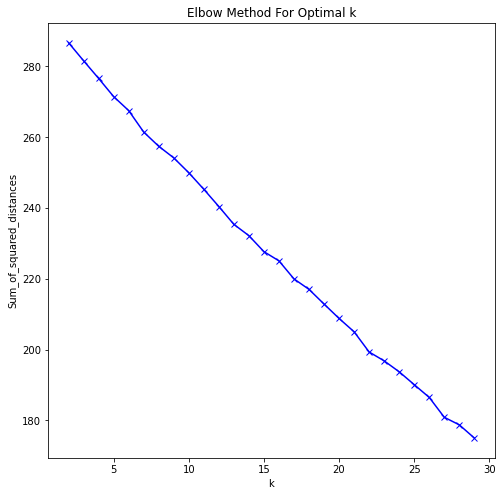

How many clusters do you want to use?


 10


In [167]:
k_means_model, results = cluster_text(text)

In [168]:
results.groupby("cluster").count()

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title
cluster,
0,35
1,81
2,55
3,20
4,28
5,8
6,24
7,16
8,16


In [318]:
corpus_topic_df['claims'] = df.claim

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [319]:
claim_list = [] 
for index, row in corpus_topic_df.sort_values(by = ["Dominant Topic", "Contribution %"], ascending=[True, False]).reset_index(drop=True).iterrows():
    
    if row["Dominant Topic"] == len(claim_list)+1 :
        claim_list.append([row["Dominant Topic"], row["Contribution %"],row["claims"]])

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [320]:
top_claim = pd.DataFrame(claim_list)

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [321]:
top_claim.columns = ["Topic", "Contribution", "Claims"]

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [322]:
top_claim

/Users/chenyongrui/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic,Contribution,Claims
0,1,30.51,"In the 2020 U.S. presidential election, Lancaster County, Pennsylvania, counted more mail-in ballots than it actually received."
1,2,22.81,"California election officials ""can literally see if you vote yes or no"" in the recall election, ""and they will throw it away if you vote yes."""
2,3,33.70,A new photograph of Malia Obama's credit card was found on Hunter Biden's laptop along with lines of cocaine on the device that Biden snorted.
3,4,33.33,"In an interview broadcast on April 4, 2021, Hunter Biden, the son of U.S. President Joe Biden, said the controversial laptop allegedly containing evidence detailing his business dealings in Ukraine ""could"" belong to him."
4,5,28.81,"“Hunter Biden was chairman of the World Food Program, which just won the Nobel Peace Prize. Eric Trump, Donald J Trump Jr, Ivanka Trump are banned from ever operating a charity again because they stole donations to children with cancer."""
